In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('./data/mnist-train.csv')
data = np.array(data)
data_binary = data[np.where(data[:,0]<2)[0]]

rows, cols = data_binary.shape
np.random.shuffle(data_binary)

#separate train data
train_data = data_binary[1000:2000].T
train_data[1:] = train_data[1:]/255. # normalizing pixels
train_data = train_data.T
print(train_data.shape)

#separate train data
dev_data = data_binary[:1000].T
dev_data[1:] = dev_data[1:]/255. # normalizing pixels
dev_labels = dev_data[0]
dev_data = dev_data[1:].T.reshape(-1, 1, 28, 28).astype(np.float32)
print(dev_data.shape)

(1000, 785)
(1000, 1, 28, 28)


In [2]:
import ray
ray.init()

2022-12-16 10:46:25,131	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [2]:
train_ds = ray.data.from_numpy(train_data)
dev_ds = ray.data.from_numpy(dev_data)

2022-12-13 17:36:39,323	INFO worker.py:1528 -- Started a local Ray instance.


In [3]:
from networks.qnn_1 import Net as QNN1

from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit import QuantumCircuit

def create_qnn(sampler):
    num_inputs = 2
    feature_map = ZZFeatureMap(num_inputs)
    ansatz = RealAmplitudes(num_inputs, reps=1)

    qc = QuantumCircuit(num_inputs)
    qc.append(feature_map, range(num_inputs))
    qc.append(ansatz, range(num_inputs))

    parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
    output_shape = 2  # parity = 0, 1

    qnn = SamplerQNN(
        sampler = sampler,
        circuit = qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        interpret=parity,
        output_shape=output_shape,
        input_gradients=True
    )
    return qnn

In [4]:
from ray import train, get
# import ray.train.torch
from ray.air import session, Checkpoint
import torch
import torch.nn as nn
from qiskit.primitives import Sampler

from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present

def train_func(config):

    dataset_shard = session.get_dataset_shard("train")

    qnn = create_qnn(Sampler()) # each worker will have their own sampler instance
    model = QNN1(qnn)
    model = train.torch.prepare_model(model)

    # Define model, optimizer, and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_func = nn.NLLLoss()

    # Start training
    epochs = 30 # Set number of epochs
    loss_list = []  # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        
        for batch in dataset_shard.iter_batches(batch_size=32):
            y_train = torch.from_numpy(batch[:,0]).long()
            x_train = torch.from_numpy(batch[:,1:].reshape(-1, 1, 28, 28)).float()

            optimizer.zero_grad(set_to_none=True)  # Initialize gradient
            output = model(x_train)  # Forward pass
            loss = loss_func(output, y_train)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize weights
            total_loss.append(loss.item())  # Store loss

        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%] tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))
        
        state_dict = model.state_dict()
        consume_prefix_in_state_dict_if_present(state_dict, "module.")
        checkpoint = Checkpoint.from_dict(dict(epoch=epoch, model_weights=state_dict))
        session.report({}, checkpoint=checkpoint)

In [5]:
from ray.air import RunConfig, ScalingConfig
from ray.train.torch import TorchTrainer

train_ref = TorchTrainer(
                train_func,
                scaling_config=ScalingConfig(use_gpu=False, use_qpu= True, num_workers=7),
#                 run_config=RunConfig(
#                         callbacks=[MLflowLoggerCallback(experiment_name="train_hybrid_qnn")]),
                datasets={"train": train_ds},
            )

results = train_ref.fit()

2022-12-13 17:36:46,433	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2022-12-13 17:36:46,434	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


(RayTrainWorker pid=18350) 2022-12-13 17:36:56,531	INFO config.py:87 -- Setting up process group for: env:// [rank=0, world_size=7]
(RayTrainWorker pid=18350) 2022-12-13 17:37:01,802	INFO train_loop_utils.py:298 -- Moving model to device: cpu
(RayTrainWorker pid=18350) 2022-12-13 17:37:01,803	INFO train_loop_utils.py:362 -- Wrapping provided model in DistributedDataParallel.


(RayTrainWorker pid=18352) Training [3%] tLoss: -0.5086
(RayTrainWorker pid=18353) Training [3%] tLoss: -0.5190
(RayTrainWorker pid=18355) Training [3%] tLoss: -0.4969
(RayTrainWorker pid=18351) Training [3%] tLoss: -0.4943
(RayTrainWorker pid=18350) Training [3%] tLoss: -0.4932
(RayTrainWorker pid=18354) Training [3%] tLoss: -0.5085
(RayTrainWorker pid=18356) Training [3%] tLoss: -0.5015


Trial name,_time_this_iter_s,_timestamp,_training_iteration,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
TorchTrainer_55960_00000,7.43668,1670949641,30,2022-12-13_17-40-41,True,,afb6d1f5b948472288df510c6866864c,0,Aberlour,30,127.0.0.1,18344,True,229.775,7.4362,229.775,1670949641,0,,30,55960_00000,0.686448


(RayTrainWorker pid=18352) Training [7%] tLoss: -0.5212
(RayTrainWorker pid=18353) Training [7%] tLoss: -0.5537
(RayTrainWorker pid=18355) Training [7%] tLoss: -0.5108
(RayTrainWorker pid=18351) Training [7%] tLoss: -0.5082
(RayTrainWorker pid=18350) Training [7%] tLoss: -0.5210
(RayTrainWorker pid=18354) Training [7%] tLoss: -0.5273
(RayTrainWorker pid=18356) Training [7%] tLoss: -0.4836
(RayTrainWorker pid=18352) Training [10%] tLoss: -0.5282
(RayTrainWorker pid=18353) Training [10%] tLoss: -0.5722
(RayTrainWorker pid=18355) Training [10%] tLoss: -0.5275
(RayTrainWorker pid=18351) Training [10%] tLoss: -0.5158
(RayTrainWorker pid=18350) Training [10%] tLoss: -0.5385
(RayTrainWorker pid=18354) Training [10%] tLoss: -0.5377
(RayTrainWorker pid=18356) Training [10%] tLoss: -0.4987
(RayTrainWorker pid=18352) Training [13%] tLoss: -0.5317
(RayTrainWorker pid=18353) Training [13%] tLoss: -0.5775
(RayTrainWorker pid=18355) Training [13%] tLoss: -0.5268
(RayTrainWorker pid=18351) Training [1

(RayTrainWorker pid=18352) Training [63%] tLoss: -0.6962
(RayTrainWorker pid=18353) Training [63%] tLoss: -0.7131
(RayTrainWorker pid=18355) Training [63%] tLoss: -0.7081
(RayTrainWorker pid=18351) Training [63%] tLoss: -0.6804
(RayTrainWorker pid=18350) Training [63%] tLoss: -0.7007
(RayTrainWorker pid=18354) Training [63%] tLoss: -0.7037
(RayTrainWorker pid=18356) Training [63%] tLoss: -0.7066
(RayTrainWorker pid=18352) Training [67%] tLoss: -0.7082
(RayTrainWorker pid=18353) Training [67%] tLoss: -0.7191
(RayTrainWorker pid=18355) Training [67%] tLoss: -0.7135
(RayTrainWorker pid=18351) Training [67%] tLoss: -0.6866
(RayTrainWorker pid=18350) Training [67%] tLoss: -0.6936
(RayTrainWorker pid=18354) Training [67%] tLoss: -0.7055
(RayTrainWorker pid=18356) Training [67%] tLoss: -0.7071
(RayTrainWorker pid=18352) Training [70%] tLoss: -0.7237
(RayTrainWorker pid=18353) Training [70%] tLoss: -0.7365
(RayTrainWorker pid=18355) Training [70%] tLoss: -0.7323
(RayTrainWorker pid=18351) Trai

2022-12-13 17:40:43,878	INFO tune.py:777 -- Total run time: 237.45 seconds (237.32 seconds for the tuning loop).


In [6]:
print(results)

Result(metrics={'_timestamp': 1670949641, '_time_this_iter_s': 7.436677932739258, '_training_iteration': 30, 'should_checkpoint': True, 'done': True, 'trial_id': '55960_00000', 'experiment_tag': '0'}, error=None, log_dir=PosixPath('/Users/ept/ray_results/TorchTrainer_2022-12-13_17-36-46/TorchTrainer_55960_00000_0_2022-12-13_17-36-46'))


In [7]:
checkpoint = results.checkpoint
checkpoint

Checkpoint(local_path=/Users/ept/ray_results/TorchTrainer_2022-12-13_17-36-46/TorchTrainer_55960_00000_0_2022-12-13_17-36-46/checkpoint_000029)

In [8]:
checkpoint_dict = checkpoint.to_dict()
print(checkpoint_dict)

qnn = create_qnn(Sampler())
model2 = QNN1(qnn)

model2.load_state_dict(checkpoint_dict.get("model_weights"))

{'epoch': 29, 'model_weights': OrderedDict([('conv1.bias', tensor([-0.1057,  0.0028])), ('conv1.weight', tensor([[[[-0.0597, -0.0244,  0.0878,  0.2693, -0.1933],
          [ 0.1108, -0.1546,  0.0082, -0.0961,  0.2919],
          [ 0.0676,  0.1113, -0.0620,  0.0784, -0.0206],
          [ 0.1188, -0.0587,  0.0559,  0.0988, -0.0180],
          [-0.0297, -0.1816, -0.0184,  0.1569, -0.0379]]],


        [[[-0.1816,  0.2219, -0.1953,  0.2815,  0.1244],
          [-0.0725,  0.2879, -0.0165, -0.0326, -0.1428],
          [-0.0963,  0.1240,  0.0606,  0.2227, -0.0436],
          [-0.1333, -0.2126, -0.0846,  0.2500,  0.1873],
          [-0.2277,  0.2234, -0.0341, -0.1694, -0.0912]]]])), ('conv2.bias', tensor([ 0.0003,  0.0558, -0.0383, -0.0418,  0.0235, -0.0974,  0.0287, -0.1081,
         0.0587,  0.0176,  0.0647, -0.0085, -0.0307,  0.0819, -0.0081, -0.0356])), ('conv2.weight', tensor([[[[ 0.1350,  0.1254, -0.0779, -0.0521,  0.0503],
          [-0.0967, -0.0521, -0.1070,  0.1134, -0.0252],
       

<All keys matched successfully>

In [9]:
from ray.train.torch import TorchCheckpoint, TorchPredictor
from ray.train.batch_predictor import BatchPredictor

check = TorchCheckpoint.from_model(model=model2)
batch_predictor = BatchPredictor.from_checkpoint(check, TorchPredictor)

predicted_probabilities = batch_predictor.predict(dev_ds)
# predicted_probabilities.show()

Map Progress (1 actors 1 pending):   0%|          | 0/1 [00:03<?, ?it/s](BlockWorker pid=18401) /opt/anaconda3/envs/serverless/lib/python3.9/site-packages/ray/air/util/data_batch_conversion.py:241: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
(BlockWorker pid=18401)   df.loc[:, col_name] = pd.Series(list(col.to_numpy()))
(BlockWorker pid=18401) /opt/anaconda3/envs/serverless/lib/python3.9/site-packages/ray/air/util/data_batch_conversion.py:221: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
(BlockWorker pid=18401)   df.loc[:, col_name] = TensorArray(col)

In [10]:
target = dev_labels
output = predicted_probabilities.to_pandas()["predictions"]

def calculate_accuracy(outputs, targets):
    correct = 0
    for output, target in zip(outputs, targets):
        output = torch.from_numpy(output)
        target = torch.from_numpy(np.asarray(target))
        pred = output.argmax(dim=0, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
    return correct/len(targets)

print(calculate_accuracy(output, target))

0.782


/opt/anaconda3/envs/serverless/lib/python3.9/site-packages/ray/air/util/data_batch_conversion.py:241: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, col_name] = pd.Series(list(col.to_numpy()))
<ipython-input-10-e6c6f4a0e5ae>:7: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:205.)
  output = torch.from_numpy(output)


In [11]:
# 1 worker: 2022-12-12 16:31:27,859	INFO tune.py:777 -- Total run time: 54.09 seconds (53.97 seconds for the tuning loop).

(BlockWorker pid=18401) /opt/anaconda3/envs/serverless/lib/python3.9/site-packages/ray/air/util/data_batch_conversion.py:241: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
(BlockWorker pid=18401)   df.loc[:, col_name] = pd.Series(list(col.to_numpy()))
(BlockWorker pid=18401) /opt/anaconda3/envs/serverless/lib/python3.9/site-packages/ray/air/util/data_batch_conversion.py:221: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
(BlockWorker pid=18401)   df.loc[:, col_name] = TensorArray(col)


In [12]:
# 2 workers: 2022-12-12 16:04:12,479	INFO tune.py:777 -- Total run time: 51.44 seconds (51.31 seconds for the tuning loop).

In [13]:
# 3 workers: 2022-12-12 16:34:27,729	INFO tune.py:777 -- Total run time: 31.56 seconds (31.43 seconds for the tuning loop).

In [14]:
# 4 workers: 2022-12-12 16:36:33,416	INFO tune.py:777 -- Total run time: 29.84 seconds (29.72 seconds for the tuning loop).

In [15]:
# 5 workers: 2022-12-12 16:37:12,278	INFO tune.py:777 -- Total run time: 23.82 seconds (23.70 seconds for the tuning loop).

In [16]:
# 6 workers: 2022-12-12 16:39:02,167	INFO tune.py:777 -- Total run time: 22.58 seconds (22.45 seconds for the tuning loop).

In [17]:
# 7 workers: 2022-12-12 16:39:46,427	INFO tune.py:777 -- Total run time: 20.63 seconds (20.50 seconds for the tuning loop).

In [18]:
# 8 workers: 2022-12-12 16:42:11,253	INFO tune.py:777 -- Total run time: 21.43 seconds (21.30 seconds for the tuning loop).

In [19]:
# 10 workers: 2022-12-12 16:41:12,307	INFO tune.py:777 -- Total run time: 22.13 seconds (22.00 seconds for the tuning loop).

In [20]:
# 14 workers: 2022-12-12 16:29:54,119	INFO tune.py:777 -- Total run time: 26.93 seconds (26.79 seconds for the tuning loop).

In [21]:
# 30 workers: 2022-12-12 16:43:14,704	WARNING callback.py:108 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
"""
Tune Status
Current time:	2022-12-12 16:49:21
Running for: 	00:06:06.63
Memory: 	19.8/64.0 GiB
System Info
Using FIFO scheduling algorithm.
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/38.05 GiB heap, 0.0/2.0 GiB objects
Trial Status
Trial name 	status 	loc
TorchTrainer_b0d53_00000	PENDING 	

2022-12-12 16:44:25,133	WARNING insufficient_resources_manager.py:128 -- Ignore this message if the cluster is autoscaling. You asked for 31.0 cpu and 0 gpu per trial, but the cluster only has 16.0 cpu and 0 gpu. Stop the tuning job and adjust the resources requested per trial (possibly via `resources_per_trial` or via `num_workers` for rllib) and/or add more resources to your Ray runtime
"""

'\nTune Status\nCurrent time:\t2022-12-12 16:49:21\nRunning for: \t00:06:06.63\nMemory: \t19.8/64.0 GiB\nSystem Info\nUsing FIFO scheduling algorithm.\nResources requested: 0/16 CPUs, 0/0 GPUs, 0.0/38.05 GiB heap, 0.0/2.0 GiB objects\nTrial Status\nTrial name \tstatus \tloc\nTorchTrainer_b0d53_00000\tPENDING \t\n\n2022-12-12 16:44:25,133\tWARNING insufficient_resources_manager.py:128 -- Ignore this message if the cluster is autoscaling. You asked for 31.0 cpu and 0 gpu per trial, but the cluster only has 16.0 cpu and 0 gpu. Stop the tuning job and adjust the resources requested per trial (possibly via `resources_per_trial` or via `num_workers` for rllib) and/or add more resources to your Ray runtime\n'

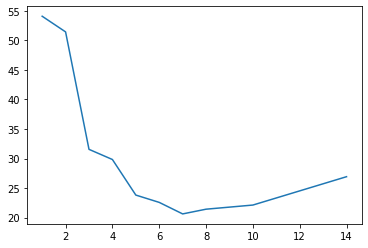

In [22]:
import matplotlib.pyplot as plt

plt.plot([1,2,3,4,5,6,7,8,10,14], [54.09, 51.44, 31.56, 29.84, 23.82, 22.58, 20.63, 21.43,22.13,26.93])
plt.show()